In [1]:
import math

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, XGate, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
oracle = QuantumCircuit(4, name="oracle")
oracle.x(2)
oracle.x(1)
oracle.compose(MCMT(ZGate(), 3, 1), inplace=True)
oracle.x(2)
oracle.x(1)

oracle.draw()

q_0: ──────■──────
     ┌───┐ │ ┌───┐
q_1: ┤ X ├─■─┤ X ├
     ├───┤ │ ├───┤
q_2: ┤ X ├─■─┤ X ├
     └───┘ │ └───┘
q_3: ──────■──────

In [ ]:
Let's see how this oracle works by applying it to the state we look for and some other state.
We look for state 1001, so let's start with it first:

In [24]:
from qiskit.quantum_info import Statevector

state = Statevector.from_label('1001')
state = state.evolve(oracle)
state.draw('latex')

<IPython.core.display.Latex object>

It was correctly multiplied by -1. - as we need.
Now let's show that it leaves other states untached, let's use 1011 as an example, but you can experiment with any state:

In [25]:
state = Statevector.from_label('1011')
state = state.evolve(oracle)
state.draw('latex')

<IPython.core.display.Latex object>

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

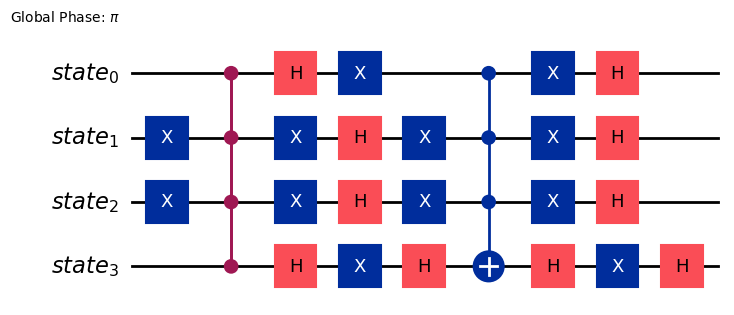

In [4]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [5]:
optimal_num_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(1 / 2**grover_op.num_qubits))))
print(optimal_num_iterations)

3


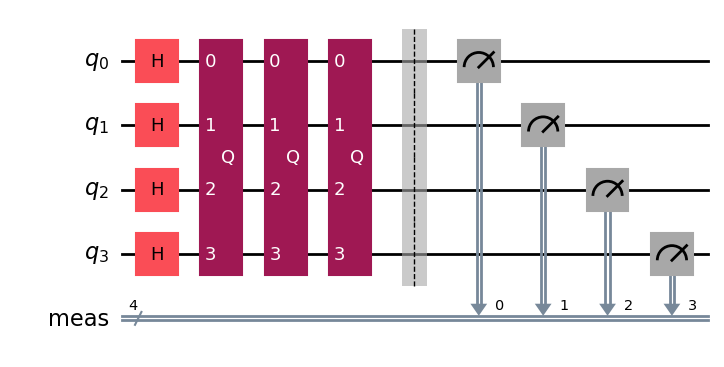

In [6]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

>>> Circuit ops (ISA): OrderedDict([('rz', 682), ('sx', 538), ('ecr', 258), ('x', 31), ('measure', 4), ('barrier', 1)])


In [8]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
job = sampler.run([isa_circuit])

print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cwx60wvtdtng0087ftp0
>>> Job Status: QUEUED


In [12]:
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


In [17]:
dist = result[0].data.meas.get_counts() 
print(dist)

{'1001': 618, '1101': 638, '1010': 577, '1000': 592, '0001': 650, '1111': 665, '0100': 625, '1011': 625, '0101': 627, '1110': 632, '0000': 764, '0110': 630, '1100': 561, '0010': 636, '0111': 631, '0011': 529}


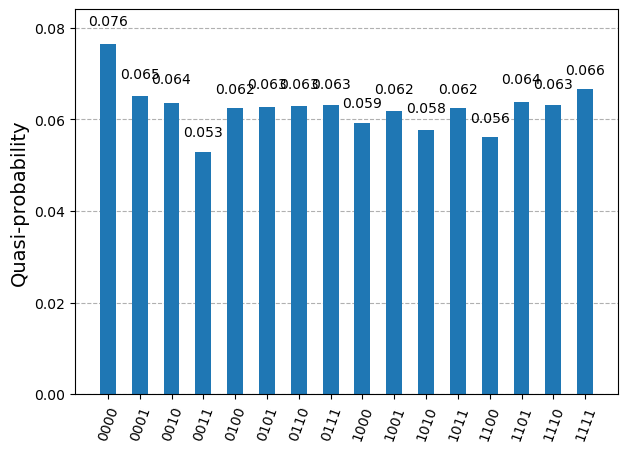

In [18]:
plot_distribution(dist)

As you can see real backend does not give too good results - none of the states is highlighted.
Let's how this looks like on simulator:

In [20]:
from qiskit.primitives import StatevectorSampler

sampler_simulator = StatevectorSampler()

num_shots = 1000000
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit_simulator = pm.run(qc)
result = sampler_simulator.run([isa_circuit_simulator], shots=num_shots).result()
data_pub = result[0].data
counts = data_pub.meas.get_counts()

for i in counts:
    counts[i] = float(counts[i]/num_shots)

print(f"The probabilities are: {counts}")

The probabilities are: {'1001': 0.961507, '1110': 0.002639, '0011': 0.00253, '0101': 0.002521, '1111': 0.002573, '0001': 0.002602, '1011': 0.002549, '1100': 0.002574, '0110': 0.002469, '0010': 0.002542, '0000': 0.002647, '0100': 0.002567, '1010': 0.002562, '1000': 0.002605, '0111': 0.002562, '1101': 0.002551}


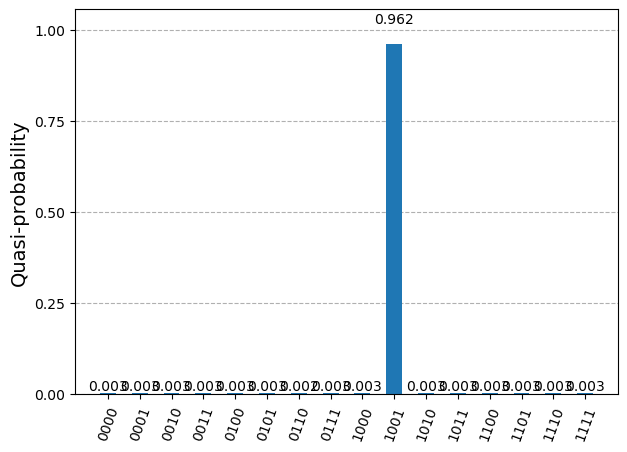

In [21]:
plot_distribution(counts)

much better :)